# Predicting Employee Churn
The purpose of this analysis is to predict when an employee will leave the company, based on standard metrics like employee satisfaction, vacation time, etc. 
After some quick exploratory analysis and data cleaning, we will toss a bunch of ML algorithms at the data and try to make some predictions!


# 1. Import Data

In [27]:
import pandas as pd
data = pd.read_csv("turnover.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction            14999 non-null float64
evaluation              14999 non-null float64
number_of_projects      14999 non-null int64
average_montly_hours    14999 non-null int64
time_spend_company      14999 non-null int64
work_accident           14999 non-null int64
churn                   14999 non-null int64
promotion               14999 non-null int64
department              14999 non-null object
salary                  14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [14]:
data.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# 2. Transform Categorical Variables
#### FYI: Here are some useful 'category' methods
```
 s.cat.categories
 s.cat.categories = list('abc')
 s.cat.rename_categories(list('cab'))
 s.cat.reorder_categories(list('cab'))
 s.cat.add_categories(['d','e'])
 s.cat.remove_categories(['d'])
 s.cat.remove_unused_categories()
 s.cat.set_categories(list('abcde'))
 s.cat.as_ordered()
 s.cat.as_unordered() ```

In [15]:
print(data.salary.unique())
print(data.department.unique())

['low' 'medium' 'high']
['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


### Salary column

In [28]:
# Change the type of the "salary" column to categorical
data.salary = data.salary.astype('category')

# Provide the correct order of categories
data.salary = data.salary.cat.reorder_categories(['low', 'medium', 'high'])

# Encode categories
data.salary = data.salary.cat.codes
data.salary[0:5]

0    0
1    1
2    1
3    0
4    0
Name: salary, dtype: int8

### Department column

#### PROTIP: Avoid the dummy trap!
- A dummy trap is a situation where different dummy variables convey the same information. In this case, if an employee is, say, from the accounting department (i.e. value in the accounting column is 1), then you're certain that s/he is not from any other department (values everywhere else are 0). Thus, you could actually learn about his/her department by looking at all the other departments.
- For that reason, **whenever n dummies are created (in your case, 10), only n - 1 (in your case, 9) of them are enough, and the n-th column's information is already included.**
- Therefore, you will get rid of the old department column, drop one of the department dummies to avoid dummy trap, and then the two DataFrames.

In [31]:
# Get dummies and save them inside a new DataFrame
departments = pd.get_dummies(data.department)

# Drop the "accounting" column to avoid "dummy trap"
departments = departments.drop("accounting", axis=1)

# Drop the old column "department" as you don't need it anymore
data = data.drop("department", axis=1)

# Join the new dataframe "departments" to your employee dataset: done
data = data.join(departments)
data.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,salary,IT,RandD,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


# 3. Descriptive Statistics

In [32]:
# Get the total number of observations and save it as the number of employees
n_employees = len(data)

# Print the number of employees who left/stayed
print(data.churn.value_counts())

# Print the percentage of employees who left/stayed
print(data.churn.value_counts()/n_employees*100)

0    11428
1     3571
Name: churn, dtype: int64
0    76.191746
1    23.808254
Name: churn, dtype: float64


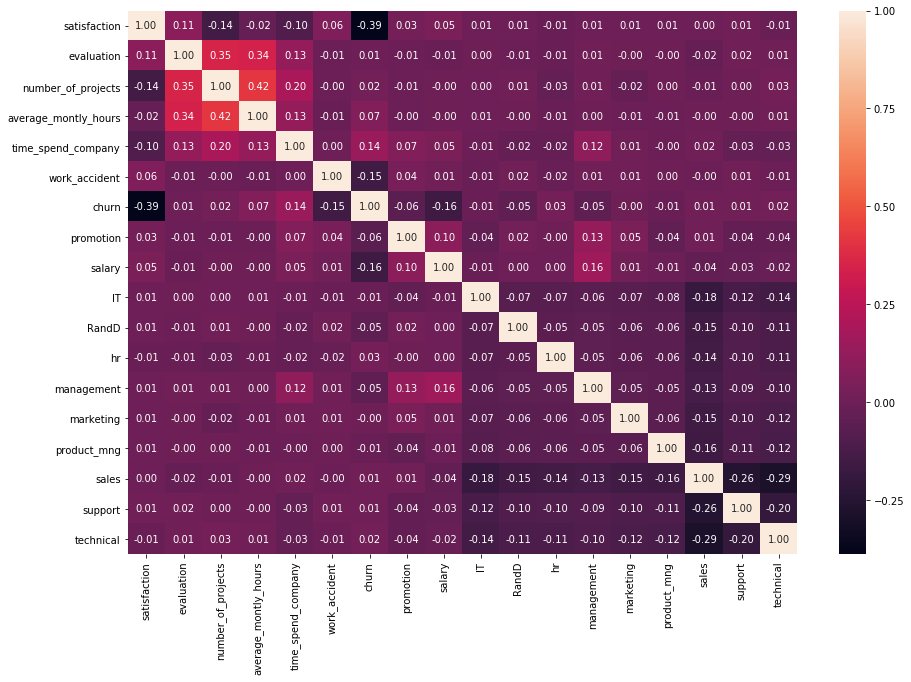

In [60]:
import seaborn as sb
import matplotlib.pyplot as plt
corr_matrix = data.corr()
plt.figure(figsize=(15,10))
sb.heatmap(corr_matrix, cbar=True, annot=True, fmt='.2f')
plt.show()

# 4. Build the model

### Seperate Train/Test data

In [252]:
# Set the target and features
# Choose the dependent variable column (churn) and set it as target
y = data.churn

# Drop column churn and set everything else as features
X = data.drop("churn",axis=1)

# Import the function for splitting dataset into train and test
from sklearn.model_selection import train_test_split

# Use that function to create the splits both for target and for features
# Set the test sample to be 25% of your observations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape)
print(y_train.shape)

# Ensure stratification worked so classes are qual in train and test sets
print(y_train.sum()/y_train.shape[0])
print(y_test.sum()/y_test.shape[0])

(11249, 17)
(11249,)
0.238065605832
0.238133333333


### Try single DT

`DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)`

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# first try a single DecisionTree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))

# Put the content of 'tree.dot' into http://webgraphviz.com/ to generate DecisionTree diagram... not that useful though
export_graphviz(model,'tree.dot')

pd.DataFrame({'Features':X.columns, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)[0:5]

Accuracy: 0.972266666667


,Features,Importance
0,satisfaction,0.499958
1,evaluation,0.153005
4,time_spend_company,0.139567
2,number_of_projects,0.098877
3,average_montly_hours,0.088262


### Try RandomForest

`RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)`

In [102]:
# First try a random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
print("Accuracy:", model.score(X_test, y_test))
pd.DataFrame({'Features':X.columns, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)[0:5]

Accuracy: 0.986933333333


,Features,Importance
0,satisfaction,0.309970
4,time_spend_company,0.192297
3,average_montly_hours,0.174615
2,number_of_projects,0.172700
1,evaluation,0.109611


### Try Voting Classifer

`VotingClassifier(estimators, voting='hard', weights=None, n_jobs=1, flatten_transform=None)`

In [293]:
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier(random_state=1)
clf_vote = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2)], voting='soft')

params = {'dt__max_depth': sp.stats.randint(3,10), 'rf__max_depth':sp.stats.randint(3,10), 
          'dt__min_samples_leaf': sp.stats.randint(10,200), 'rf__min_samples_leaf':sp.stats.randint(2,200)}

rnd_search = RandomizedSearchCV(clf_vote, param_distributions=params,
                                n_iter=10, return_train_score=True)

rnd_search.fit(X_train, y_train)
print("Accuracy:", rnd_search.score(X_test, y_test))

Accuracy: 0.974133333333


# 5. Tune RandomForest Model with RandomizedSearchCV
```
RandomizedSearchCV(estimator, param_distributions, n_iter=10, scoring=None, fit_params=None, n_jobs=1, iid=True, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score='raise', return_train_score='warn')
```

In [332]:
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp

# Set estimator
model = RandomForestClassifier(random_state=42, criterion='gini', max_features='auto', n_estimators=50)
# Set param grid
params = {'max_depth':sp.stats.randint(4,15),
          'min_samples_leaf': sp.stats.randint(10,200), 
          'class_weight':['balanced', None]}

# Set RSCV, MAKE SURE TO USE ROC SCORNG
rnd_search = RandomizedSearchCV(estimator=model, 
                   param_distributions=params, 
                   n_iter=50, 
                   scoring='roc_auc', 
                   cv=3,
                   refit=True,
                    return_train_score=True)

# Run model
rnd_search.fit(X_train, y_train)
print("Accuracy:", rnd_search.score(X_test, y_test))
print("Best params:", rnd_search.best_params_)

Accuracy: 0.987229260679
Best params: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 14}


In [317]:
score_cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_max_depth', 'param_min_samples_leaf', 'param_class_weight']

pd.DataFrame(rnd_search.cv_results_).sort_values('mean_test_score', ascending=False)[score_cols].reset_index(drop=True)[0:10]

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_max_depth,param_min_samples_leaf,param_class_weight
0,0.985719,0.002451,0.991680,0.000203,13,19,None
1,0.985204,0.002463,0.991480,0.000531,11,25,balanced
2,0.983757,0.002558,0.989704,0.000239,10,21,None
3,0.982740,0.002327,0.988336,0.000425,10,26,None
4,0.980986,0.002156,0.984566,0.000795,7,21,None
5,0.980792,0.002676,0.984424,0.000623,14,64,balanced
6,0.979835,0.002910,0.983232,0.000896,10,73,balanced
7,0.979658,0.001134,0.983707,0.001081,6,11,None
8,0.979201,0.002923,0.982187,0.000505,8,73,balanced
9,0.978680,0.002797,0.980866,0.000732,7,62,None


# 6. Evaluate Model

#### PRO TIP: Choose your evaluation metric based on your business objective
- If target is leavers, focus in False Negative (FN): Priority is on identifying people at risk of leaving
    - Recall = TP / (TP+FN) = % of correct predictions amoung true 1s (leavers)
    - Focused on false negatives
    - Lower FN, higher recall
- If target is staying, focus on False Positive (FP): Prioirty is identifying people who are likely to stay
    - Specificity = TN / (TN+FP) = % of correct predictions among true 0s (stayers)
    - Lower FP, higher specificity score
- Even if your target is 'leavers', you may also want to use the Precision Score:
    - Precision = TP / (TP+FP) = % of true 1s (leavers) among those predicted to leave
    - Focused on false positives
    - Lower FP, higher Recall
    - So if you have a Precision of 94%, then of your predicted 1s, only 94% were correct

#### Remember:
- Recall: Focused on False Negatives (how many positives you missed)
- Precision: Focused on False Positives (how many predicted positves are wrong)

In [333]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Assign best_estimator_ from RandomSearchCV to model variable
model = rnd_search.best_estimator_

# Get model predictions
y_hat = model.predict(X_test)

# Print metrics
print("Accuracy:" , accuracy_score(y_test, y_hat))
print("Precision:" , precision_score(y_test, y_hat))
print("Recall:" , recall_score(y_test, y_hat))
pd.DataFrame(confusion_matrix(y_test, y_hat),columns=['Stay','leave'], index=['Stay','leave'])
print()
print("Model identifies {:.3%} of 'leavers'".format(recall_score(y_test, y_hat)))

Accuracy: 0.975733333333
Precision: 0.987834549878
Recall: 0.909294512878

Model identifies 90.929% of 'leavers'


### Calculate the ROC
- While recall score is important for measuring the percentage of positive cases you capture, it can put too much weight on the number of False Negatives. On the other hand, precision is concentrated on the number of False Positives
- For example, if you built a model that **simply predicted 100% employee churn**:
    - your FN would be 0, because you didn't predict any 0s, and therefore didnt incorrecyl classify any observations as negative
    - Your FP would be super high, because you classifed EVERYTHING as positive
    - **Recall score would be 100%** (because you captured all of the positive cases by default)
    - **Precision score would be low**, because of the you have tons of false positives


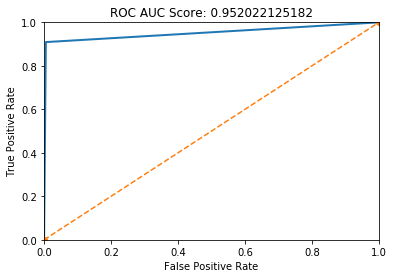

In [319]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr,tpr, thresholds = roc_curve(y_test, y_hat)

def plot_roc_curve(fpr,tpr,lw, label=None):
    plt.plot(fpr,tpr,linewidth=lw,label=label)
    plt.plot([0,1],[0,1],'o--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC AUC Score: " + str(roc_auc_score(y_test,y_hat)))
plot_roc_curve(fpr, tpr,lw=2)
plt.show()

# 7. Extract Feature Importances and Retrain Best RF Model
- Feature importance for decision trees is calculated as the relative decrease in Gini due to the select feature (they may also be calculated using the average tree depth of a feature, as usually features lower in the tree are less important)
- Importances are scaled up to sum to 100%, so the high percentage, the higher the importance


In [334]:
# Extract feature importances
feat_import = pd.DataFrame({'features':X.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
print(feat_import[0:5])

# Extract meaningful features
selected_feats = feat_import['features'][feat_import['importance']>0.01]

               features  importance
0          satisfaction    0.337467
4    time_spend_company    0.201247
2    number_of_projects    0.190811
3  average_montly_hours    0.132675
1            evaluation    0.116380


In [342]:
# Retrain best model
model2 = RandomForestClassifier(max_depth=13, min_samples_leaf=19, class_weight=None, n_estimators=10)
model2.fit(X_train[selected_feats], y_train)
y_hat = model2.predict(X_test[selected_feats])

print("Accuracy:" , accuracy_score(y_test, y_hat))
print("Precision:" , precision_score(y_test, y_hat))
print("Recall:" , recall_score(y_test, y_hat))
print("Final auc_roc score:" , roc_auc_score(y_test, predict2))

print("Model identifies {:.3%} of 'leavers'".format(recall_score(y_test, y_hat)))

Accuracy: 0.9736
Precision: 0.976019184652
Recall: 0.911534154535
Final auc_roc score: 0.953841981013
Model identifies 91.153% of 'leavers'


### Wooohooo! Our final model, with only 5 features slightly outperforms the models with 17 features! And it will probably train and predict faster in production piplines. 